In [1]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.preprocessing as pp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.signal import triang
import torch
from torch import nn
import time
from tqdm import tqdm
from scipy.signal import decimate
from scipy import interpolate
from torchinfo import summary
import torch.nn.functional as F
from sklearn.model_selection import train_test_split



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device); print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 4080


In [3]:
CO2_Maps = np.load('data/co2maps/co2_maps.npy')
print(CO2_Maps.shape)
CO2_Maps = CO2_Maps.reshape(CO2_Maps.shape[0]*CO2_Maps.shape[1],CO2_Maps.shape[2],CO2_Maps.shape[3])
print(CO2_Maps.shape)


(40, 39, 300, 200)
(1560, 300, 200)


In [5]:
class myDeconv(nn.Module):
    def __init__(self, conv, output_size):
        super(myDeconv, self).__init__()
        self.output_size = output_size
        self.conv = conv
        
    def forward(self, x):
        batch_size = x.shape[0]
        ch_size = x.shape[1]
        x = self.conv(x, output_size=(batch_size,ch_size,self.output_size[0],self.output_size[1]))
        return x
    
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size,self.shape[0],self.shape[1],self.shape[2]) 
    
class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)   
    
class AutoEncoder(nn.Module): 
    def __init__(self, neurons=1, kernsz = 4, starting_neurons=1):
        super().__init__()
        #original data is #10,300,200 (nz,nx)
        #output is 15,10
        
        self.encoder = nn.Sequential(
            nn.Conv2d(starting_neurons,neurons*4,stride=5,kernel_size=kernsz,padding=1), #60,40
            nn.Conv2d(neurons*4,neurons*4,stride=1,kernel_size=kernsz,padding='same'),
            nn.ReLU(),
            nn.Conv2d(neurons*4,neurons*8,stride=2,kernel_size=kernsz,padding=1), #30,20
            nn.Conv2d(neurons*8,neurons*8,stride=1,kernel_size=kernsz,padding='same'),
            nn.ReLU(),
            nn.Conv2d(neurons*8,neurons*16,stride=2,kernel_size=kernsz,padding=1), #15,10
            nn.Conv2d(neurons*16,neurons*16,stride=1,kernel_size=kernsz,padding='same'),
            nn.ReLU(),
            nn.Conv2d(neurons*16,starting_neurons,stride=1,kernel_size=kernsz,padding='same'), #15,10
            nn.Tanh(),
            )    
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(starting_neurons,neurons*16,stride=2,kernel_size=kernsz,padding=1), #30,20
            nn.Conv2d(neurons*16,neurons*16,stride=1,kernel_size=kernsz,padding='same'),
            nn.ReLU(),
            nn.ConvTranspose2d(neurons*16,neurons*8,stride=2,kernel_size=kernsz,padding=1), #60,40
            nn.Conv2d(neurons*8,neurons*8,stride=1,kernel_size=kernsz,padding='same'),
            nn.ReLU(),
            nn.ConvTranspose2d(neurons*8,neurons*4,stride=5,kernel_size=kernsz,padding=0,output_padding=1), #300,200
            nn.Conv2d(neurons*4,neurons*4,stride=1,kernel_size=kernsz,padding='same'),
            nn.ReLU(),
            nn.Conv2d(neurons*4,starting_neurons,stride=1,kernel_size=kernsz,padding='same'),
            )
        
    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [ ]:
model = AutoEncoder(neurons=2,kernsz=4,starting_neurons=1).to(device)
summary(model, input_size=(13,1,300,200))

In [9]:
def weights_init(m):
    '''Ensure weights initialization same as tensorflow'''
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
        
def to_np(input):
    return input.detach().cpu().numpy()

def load_batch(dataset, batch_size=1,random=True):
    '''batch_size must be factor of len(dataset)'''
    total_samples = len(dataset)
    n_batches = int(total_samples/ batch_size)
    
    if random==True:
        indices = np.random.choice(total_samples,size=total_samples,replace=False)
    else:
        indices = np.arange(0,total_samples)
    
    for i in range(0, total_samples, batch_size):
        batch_indices = indices[i:i+batch_size]
        
        batch = dataset[batch_indices]
        
        yield batch
        

In [ ]:
images = torch.tensor(CO2_Maps)
images = images.to(device).double()
images = images[:,None,:,:]
print(images.shape)

BS = 40
total_samples = len(images)
#total number of batches
n_batches = int(total_samples/ BS)
#print out progress after every x batches (e.g., after 10 batches)
print_batches = 3


In [6]:
model = AutoEncoder(neurons=2,kernsz=4,starting_neurons=1).to(device).double() 
lr = 0.001 #0.001 original
loss_fn_mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
record_NNLoss = []
main_log=dict()
num_epochs = 1000
print('''Start Training Loop!''')
for epoch in range(num_epochs):
    print('\n')
    print('''Epoch {} '''.format(epoch))
    
    batch_NNLoss = []
    for batch_i, batch_real in enumerate(load_batch(images,batch_size=BS)):
        
        #zero the parameter gradients
        optimizer.zero_grad()
        #activate model training
        model.train()
        #predict Sg from Seismic Gather
        pred = model(batch_real)
        #calculate loss 
        Loss = loss_fn_mse(pred,batch_real) #mse loss
        
        #Backpropagate
        Loss.backward()
        #Apply optimizer
        optimizer.step()
        
        #Print out batch progress
        if batch_i % print_batches == 0:
            print('[%d/%d], Batch:[%d/%d]\t NN_Loss: %.9f \t '
                  % (epoch,num_epochs,batch_i,n_batches,Loss.item()))
        #Save batch losses
        batch_NNLoss.append(Loss.item())
        
    #Compute epoch losses
    epoch_NNLoss = np.mean(batch_NNLoss)
    
    #Print out Epoch Progress
    print('EPOCH %d Training -> NN_Loss: %.9f \t ' 
           %(epoch,epoch_NNLoss))

    #Save only the lowest score
    if epoch > 0:
        if epoch_NNLoss < np.min(record_NNLoss):
            print('Saving Lowest Loss!!')
            torch.save(model.state_dict(),'data/weights_logs/SeisCO2Net_AE.pth')
        else:
            print('Nawh.... ')
        
    #save epoch progress
    record_NNLoss.append(epoch_NNLoss)
    
    #save into dictionary
    main_log['NNLoss'] = record_NNLoss
    
    #save
    np.save('data/weights_logs/SeisCO2Net_AE_logs.npy',main_log)

#### Encode CO2 Maps

In [7]:
# #load weights
model = AutoEncoder(neurons=2,kernsz=4, starting_neurons=1).to(device).double() 
model.load_state_dict(torch.load('data/weights_logs/SeisCO2Net_AE.pth'))

# ####Encode all images
# all_encoded = model.encoder(images)
# all_encoded_np = to_np(all_encoded)
# print(all_encoded_np.shape)
# np.save('data/co2maps/co2_maps_enc.npy',all_encoded_np)



<All keys matched successfully>

In [10]:
all_encoded_np = np.load('data/co2maps/co2_maps_enc.npy')[:400] #do not want to load all
all_encoded = torch.tensor(all_encoded_np).to(device)
all_decoded = model.decoder(all_encoded)
all_decoded_np = to_np(all_decoded)
print(all_decoded_np.shape)


(400, 1, 300, 200)


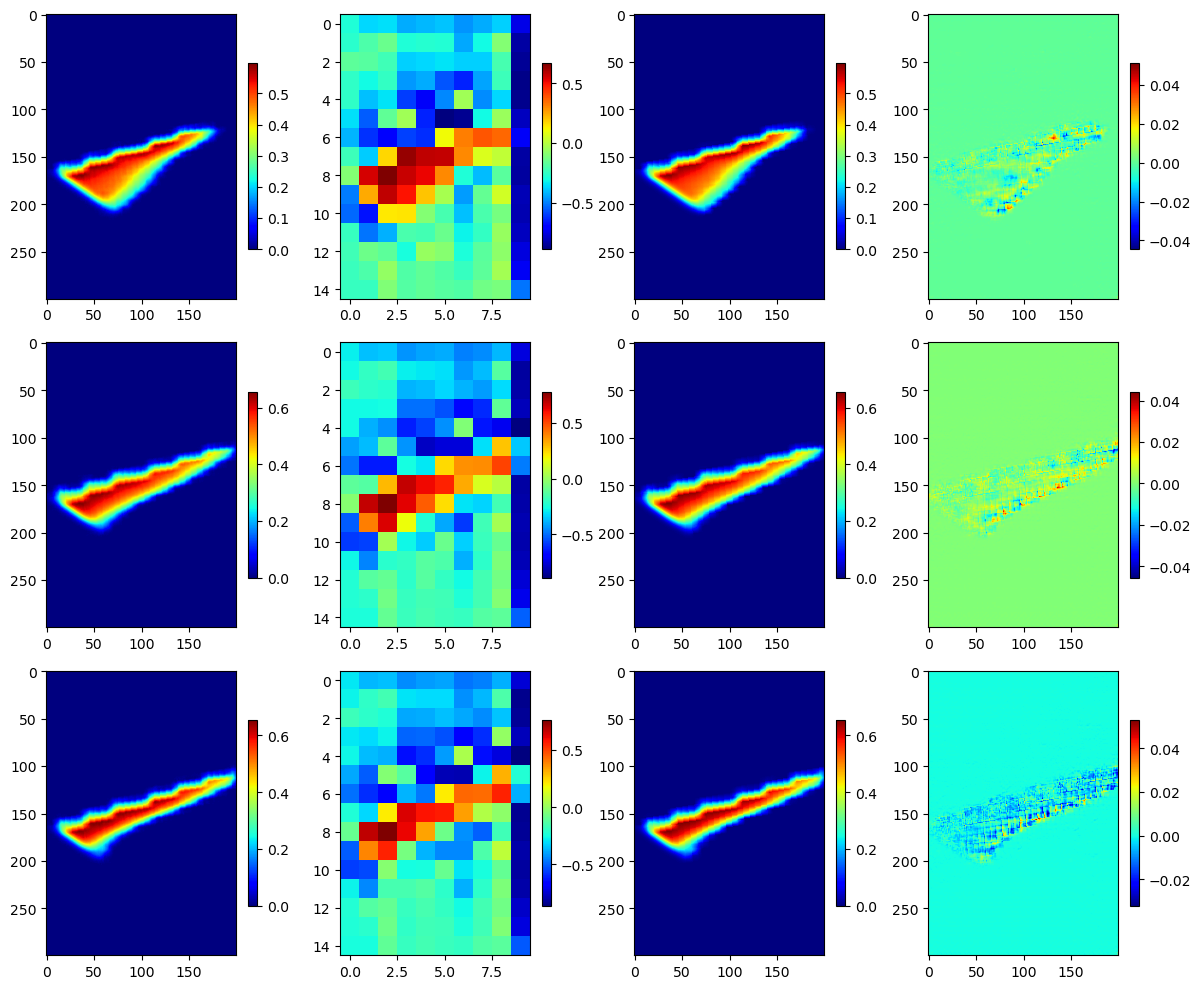

In [11]:
#decode check

fig,axs = plt.subplots(3,4,figsize=(12,10))
for i in range(3):
    
    n1 = np.random.randint(400)
    enc = np.squeeze(all_encoded_np[n1])
    img = torch.tensor(enc).to(device).double()[None,None,:,:]
    out = model.decoder(img)
    out = to_np(out)[0,0]
    residual = (out - CO2_Maps[n1])
    im0 = axs[i,0].imshow(out,cmap='jet',vmin=CO2_Maps[n1].min(),vmax=CO2_Maps[n1].max())
    im1 = axs[i,1].imshow(enc,cmap='jet')
    im2 = axs[i,2].imshow(CO2_Maps[n1],cmap='jet',vmin=CO2_Maps[n1].min(),vmax=CO2_Maps[n1].max())
    im3 = axs[i,3].imshow(residual,cmap='jet')
    fig.colorbar(im0,ax=axs[i,0],fraction=0.04)
    fig.colorbar(im1,ax=axs[i,1],fraction=0.04)
    fig.colorbar(im2,ax=axs[i,2],fraction=0.04)
    fig.colorbar(im3,ax=axs[i,3],fraction=0.04)
fig.tight_layout()
